In [25]:
import matplotlib.pyplot as plt
import os
import numpy as np

def make_file_path(name, get_all=False, num=0):
    """
    构造文件路径
    name:患者编号，如A1, B2, C3, ...
    get_all:是否返回所有路径（五个）, 默认为 False,选择true时 num 参数无效
    num:只返回该患者的一个路径，1~5.
    该函数不做数据是否存在的检查。
    """
    current_path = os.getcwd()
    file_paths = []
    if get_all:
        for i in range(1, 6):
            sample_name = "samples_0_" + name + "_" + str(i) + ".txt"
            file_paths.append(os.path.join(current_path, "txt", sample_name))
    else:
        sample_name = "samples_0_" + name + "_" + str(num) + ".txt"
        file_paths.append(os.path.join(current_path, "txt", sample_name))
    return file_paths

def get_datas(name, get_all=False, num=0):
    """
    name:患者编号，如A1, B2, C3, ...
    get_all:是否返回所有数据，默认为 False,选择true时 num 参数无效
    num:返回该患者的某一个数据，1~5.
    """
    file_paths = make_file_path(name, get_all, num)
    datas = []
    for file_path in file_paths:
        if os.path.exists(file_path):
            x, y = [], []  # Reset x and y for each file
            with open(file_path, 'r') as file:
                for line in file:
                    # 按空格分隔每行数据
                    parts = line.strip().split()
                    if len(parts) == 2:
                        x.append(float(parts[0]))
                        y.append(float(parts[1]))
            data = np.array([x, y])
            datas.append(data)
        else:
            return False
    return {"name":name,"datas":datas}

def get_all_patients_datas():
    """
    获取所有患者的数据
    返回一个列表，列表中的每个元素是一个字典，字典包含三个键：col, index, datas。
    col: 列名
    index: 行号
    """
    # cols = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]
    cols = ["P"]
    all_patients_datas = []  # 使用列表存储每个患者的数据
    for col in cols:
        for i in range(1, 25):
            datas = get_datas(col + str(i), get_all=True)
            if datas:
                # 将每个患者的数据存储为字典
                all_patients_datas.append(datas)
            else:
                break
    return all_patients_datas

gapd=get_all_patients_datas()

In [24]:
"""
进行三部分的数据准备
1. 三次插条等采样
2. 平滑滤波
3. 基线调整
"""
import numpy as np
import pywt
from scipy.interpolate import CubicSpline
from scipy.ndimage import grey_opening, grey_closing
from scipy.signal import savgol_filter,find_peaks, cwt, ricker
from getdata import get_all_patients_datas, get_datas
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt

def gaussian(x, a, b, c):
    """
    高斯函数
    :param x: 自变量
    :param a: 振幅
    :param b: 峰中心
    :param c: 标准差
    :return: 高斯函数值
    """
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

def plot_patient_data(patient_datas, datas_labels,get_all=False, num=0,xlim=None):
    """
    绘制单个患者的折线图
    :param patient_data: 单个患者的数据字典，包含 "name" 和 "datas"
    """
    if(xlim==None):
        xlim=(0,1000)
    plt.figure(figsize=(10, 6))

    linewidth = 0.5
    labels=datas_labels
    name = patient_datas[0]["name"]

    if(get_all):
        j=0
        for patient_data in patient_datas:
            for i, data in enumerate(patient_data["datas"]):
                x, y = data  # 提取 x 和 y
                # Filter data points within xlim range
                mask = (x >= xlim[0]) & (x <= xlim[1])
                x = x[mask]
                y = y[mask]
                plt.plot(x, y, label=labels[j], linewidth=linewidth)  # 绘制折线图
                j=j+1
    else:
        j=0
        for patient_data in patient_datas:
            data = patient_data["datas"][num-1]
            x, y = data
            mask = (x >= xlim[0]) & (x <= xlim[1])
            x = x[mask]
            y = y[mask]
            if(labels[j]=="extracted"):
                y = np.abs(y)
            plt.plot(x, y, label=labels[j], linewidth=linewidth)
            j=j+1

    plt.xlabel("X轴")
    plt.ylabel("Y轴")
    plt.title(f"{name} 折线图")
    plt.legend()
    plt.grid(True)
    plt.show()


def cubic_spline_resample(patient):
    resampled_datas=[]
    datas = patient["datas"]
    for data in datas:
        x, y = data
        cs = CubicSpline(x, y)
        y_new = cs(x)
        data = np.array([x, y])
        resampled_datas.append(data)
    resampled_patient={
        "name": patient["name"],
        "datas": resampled_datas
    }
    return resampled_patient

def wavelet_smooth(patient):
    """
    使用 db4 小波对患者数据进行 4 层分解并平滑
    :param patient: 包含 "name" 和 "datas" 的患者数据字典
    :return: 平滑后的患者数据字典
    """
    smoothed_datas = []
    level = 4  # 小波分解的层数
    for data in patient["datas"]:
        x, y = data  # 提取 x 和 y 数据
        # 小波分解
        coeffs = pywt.wavedec(y, 'db4', level=4)
        sigma = np.median(np.abs(coeffs[-level] - np.median(coeffs[-level]))) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(y)))
        
        # 软阈值处理（所有高频系数层）
        denoised_coeffs = [coeffs[0]]  # 保留近似系数（低频）
        for i in range(1, level + 1):
            denoised_coeffs.append(pywt.threshold(coeffs[i], threshold, mode='soft'))

        # 重构信号
        y_smooth = pywt.waverec(coeffs, 'db4')
        # 确保重构后的数据长度与原始数据一致
        y_smooth = y_smooth[:len(y)]

        # 将平滑后的数据存储
        smoothed_datas.append(np.array([x, y_smooth]))
    # 返回平滑后的患者数据
    smoothed_patient = {
        "name": patient["name"],
        "datas": smoothed_datas
    }
    return smoothed_patient

def baseline_correct(patient):
    """
    对患者数据进行基线调整
    :param patient: 包含 "name" 和 "datas" 的患者数据字典
    :return: 基线调整后的患者数据字典
    """
    corrected_datas = []
    for data in patient["datas"]:
        x, y = data
        # 创建一个足够大的结构元素进行开运算
        kernel_size = len(y) // 200  # 可调整大小
        # 开运算（先腐蚀后膨胀）
        baseline = grey_opening(y, size=kernel_size)
        baseline = grey_closing(baseline, size=kernel_size)
        baseline = savgol_filter(baseline, window_length=kernel_size, polyorder=3)  # 平滑基线
        # 减去基线
        y_corrected = y - baseline
        corrected_datas.append(np.array([x, y_corrected]))

    corrected_patient = {
        "name": patient["name"],
        "datas": corrected_datas
    }
    return corrected_patient

def peak_extract(patient):
    extracted_datas = []
    min_snr=3
    for data in patient["datas"]:
        x, y = data
        # 二阶连续小波变换
        scales = np.arange(1, 20) 
        coefficients = np.zeros((len(scales), len(y)))
        for i, scale in enumerate(scales):
            wavelet = pywt.cwt(y, scales=[scale], wavelet='mexh')[0][0]
            coefficients[i] = wavelet
        # 锐化以后的y
        y_sharpend=np.abs(np.sum(coefficients,axis=0))
        mask=np.zeros(len(y))
        # 提取局部最大值（一阶导数在peak附近符号改变）
        left_derivative = np.diff(y_sharpend[:-1])
        right_derivative = np.diff(y_sharpend[1:])
        peaks = ((left_derivative > 0) & (right_derivative < 0)).nonzero()[0]
        for peak in peaks:
            # 计算局部信噪比
            if(x[peak]<=300):
                window = 500
            else:
                window = 10000
            local_signal = y_sharpend[peak]
            local_noise = np.mean(y_sharpend[max(0, peak - window//2) : min(len(y), peak + window//2)])
            snr = local_signal / local_noise
            if snr > min_snr:
                mask[peak] = 1
        extracted_data = mask*y
        extracted_datas.append(np.array([x, extracted_data]))

    extracted_patient = {
        "name": patient["name"],
        "datas": extracted_datas
    }
    return extracted_patient


#峰面积拟合（高斯函数）
def peak_area_fitting(patient):
    fitted_datas = []
    for data in patient["datas"]:
        x, y = data
        peaks, _ = find_peaks(y, height=0)
        areas = []
        for peak in peaks:
            try:
                # 使用高斯函数拟合每个峰
                popt, _ = curve_fit(gaussian, x, y, p0=[max(y), x[peak], 1])
                areas.append(popt[0])  # 保存峰面积
            except RuntimeError as e:
                # 如果拟合失败，记录失败的峰位置
                print(f"拟合失败在峰位置 {peak}: {e}")
                areas.append(0)  # 用0代替失败的拟合结果
        fitted_datas.append(np.array([x, np.array(areas)]))
    fitted_patient = {
        "name": patient["name"],
        "datas": fitted_datas
    }
    return fitted_patient


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks, cwt, ricker, savgol_filter
from scipy.ndimage import grey_opening, grey_closing
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize
import pywt
from scipy.optimize import curve_fit
from scipy.spatial import KDTree  

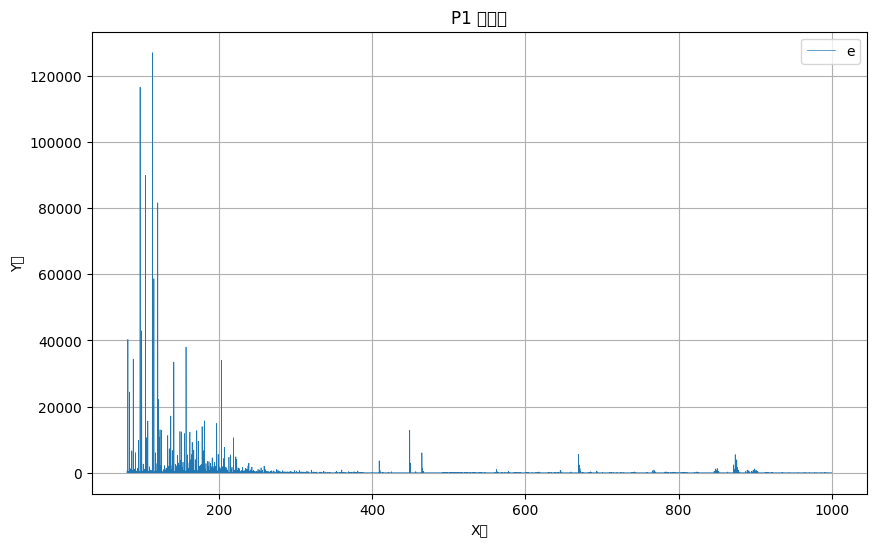

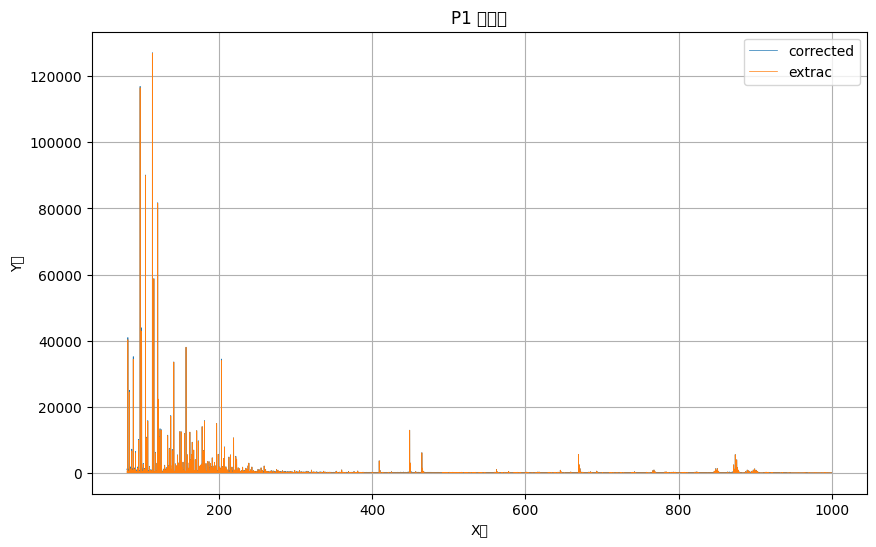

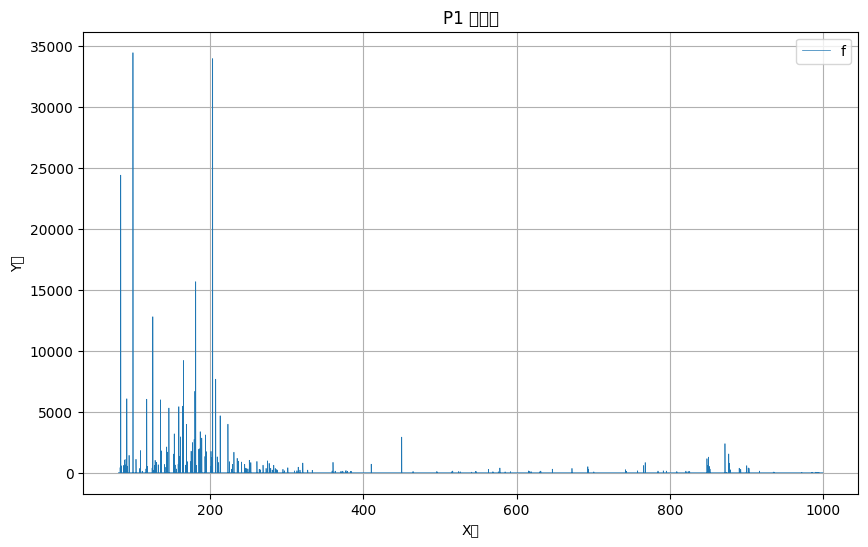

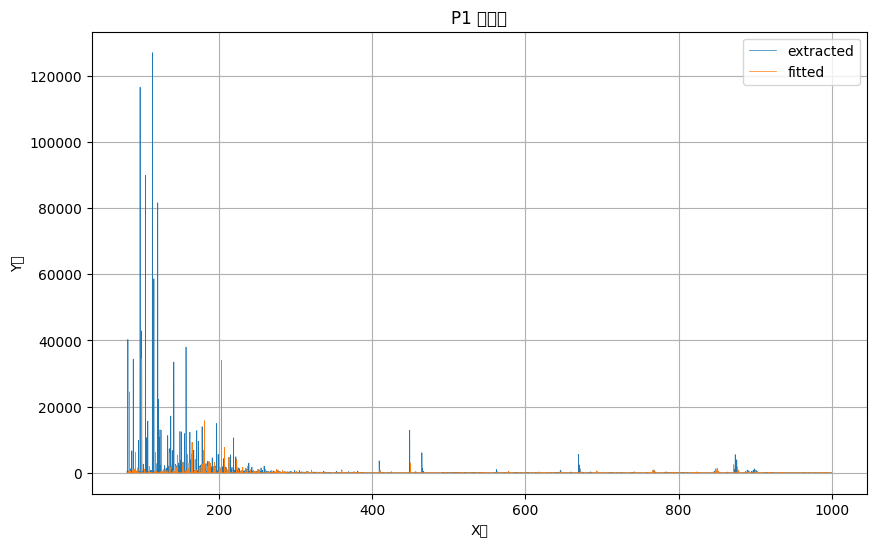

848


In [30]:
def prepare():
    all_patients_datas = get_all_patients_datas()
    prepared_datas,resampled_datas,smoothed_datas,corrected_datas,extracted_datas,fitted_datas,num_peaks=[],[],[],[],[],[],[]
    for patient in all_patients_datas:
        resampled_data = cubic_spline_resample(patient)
        resampled_datas.append(resampled_data)
        smoothed_data = wavelet_smooth(resampled_data)
        smoothed_datas.append(smoothed_data)
        corrected_data = baseline_correct(smoothed_data)
        corrected_datas.append(corrected_data)
        extracted_data = peak_extract(corrected_data)
        extracted_datas.append(extracted_data)
        fitted_data = peak_extract(extracted_data)
        fitted_datas.append(fitted_data)

        # 该病人第一组数据y不为0的点数（峰值数量）
        num_peaks.append(np.sum(extracted_data["datas"][0][1] > 0))

    return all_patients_datas,extracted_datas,fitted_datas,num_peaks

if __name__ == "__main__":
    (ad,ed,fd,num_peaks)=prepare()
    plot_patient_data(([ed[0]]),("extracted"),get_all=False,num=1)
    plot_patient_data((ad[0],ed[0]),("corrected","extrac"),get_all=False,num=1)
    plot_patient_data(([fd[0]]),("fitted"),get_all=False,num=1)
    plot_patient_data((ed[0],fd[0]),("extracted","fitted"),get_all=False,num=1)
    print(num_peaks[0])
